In [1]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_models/NVspin_SimpleRNN_model_cuda.h5')

2023-09-14 14:22:25.256821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 14:22:26.924596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-14 14:22:29.481413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 14:22:29.982827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-14 14:22:29.982914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_exec

In [2]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm, fractional_matrix_power

#########################################################################

# pauli matrix 
sx = np.array([[0,  1],     [1, 0]])
sy = np.array([[0, -1j],   [1j, 0]])
sz = np.array([[1, 0],     [0, -1]])
s0 = np.array([[1, 0],      [0, 1]])

# parameters(detuning factor)
v0 = 0.02           # Arbitrary settings, Actual speed : 0.04rad/μs
d0 = 0.15           # Arbitrary settings, Actual speed : 0.30rad/μs
dt = 2.6 


# unitary operator
def unitary(dt, choice):
    
    # Select x,y-rotation direction.
    # [stay, +x, -x, +y, -y]
    choice_list = [0, 1, -1, 1, -1] 
    
    if choice < 3:
        # if choice = 0 ... only d0*sz
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else:
        Ham = (d0*sz+v0*choice_list[choice]*sy)

    # Creating a Unitary Operator for each of the four sections by Hamiltonian
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    
    return U_e


#########################################################################

# x-rotation operater
def Rx(theta):
    return np.matrix([  [cos(theta/2),    -1j*sin(theta/2)],
                        [-1j*sin(theta/2),    cos(theta/2)]])

# z-rotation operater
# Do not use Rz. Control by rotation only by Hamiltonian.
def Rz(phi): 
    return np.matrix([  [cos(phi/2)-1j*sin(phi/2),  0],
                        [0,  cos(phi/2)+1j*sin(phi/2)]])

# Calculating the Fidelity
def state_fidelity(rho_1, rho_2): 
    
    # rho_1(current state), rho_2(target state)
    # Calculate the fidelity after checking the dimensions of the two states.
    
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)


#########################################################################

init_wave = np.array([[1], [0]])
irho_init = np.kron(init_wave,init_wave.conj().T)


def fidelity(target_theta, target_phi):
    
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @ target_U.conj().T

    new_theta = np.array(target_theta).reshape(-1, 1)
    new_phi = np.array(target_phi).reshape(-1, 1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)

    Uni = s0
    U_0 = unitary(dt, 0)
    U_1 = unitary(dt, 1)
    U_2 = unitary(dt, 2)
    U_3 = unitary(dt, 3)
    U_4 = unitary(dt, 4)
    
    pulse_list = [U_0, U_1, U_2, U_3, U_4]
    
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [3]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     
     target_theta = np.pi / 180 * random.uniform(0,180)
     target_phi = np.pi / 180 * random.uniform(0,360)
     
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     
     sum += temp

print(sum/iter)

1/1 [==============================] - 0s 26ms/step


2023-09-14 14:22:33.833566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 29ms/step
0.9860108833174444


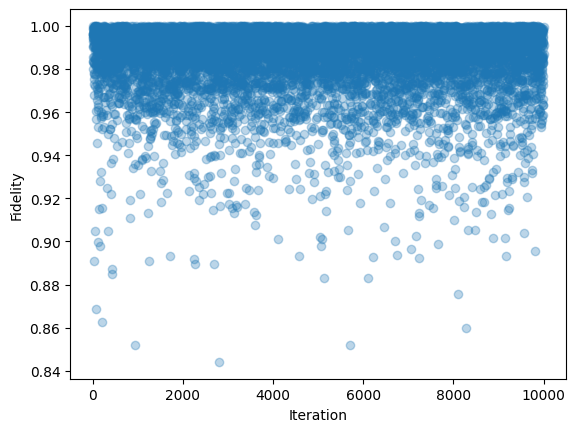

In [4]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [5]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

3 0.983376624885404
7 0.9855542685857136
8 0.9797921238814273
12 0.9837769966119642
20 0.9730297443500285
24 0.9826349939148737
30 0.9780409400227961
31 0.9752080481497082
33 0.9828645710378605
37 0.9680737789387763
38 0.9776817250159829
39 0.9856957067751804
40 0.8910883811275367
41 0.9047768605971839
42 0.9881914974266007
44 0.985158972764228
49 0.9844895610520096
51 0.9818253143079899
59 0.9771967417113356
62 0.972084386266771
63 0.9898084952982728
64 0.9812280338890071
66 0.9854643970192326
67 0.8686180878463073
70 0.9778526886695665
74 0.9896658472078926
75 0.9605185444818173
77 0.9850677403695292
80 0.9834223049525557
81 0.9888091857010779
82 0.9569759934074807
83 0.989654302050589
85 0.9819080500512172
87 0.9868633950912431
89 0.9454495284431806
93 0.9788874170875556
94 0.982356015485519
98 0.9709368731481651
99 0.9877207563134325
101 0.980098242415547
102 0.9731496461355964
103 0.9893435060668382
105 0.9655770332309498
109 0.9639737503222883
111 0.9687833782094087
114 0.9529457

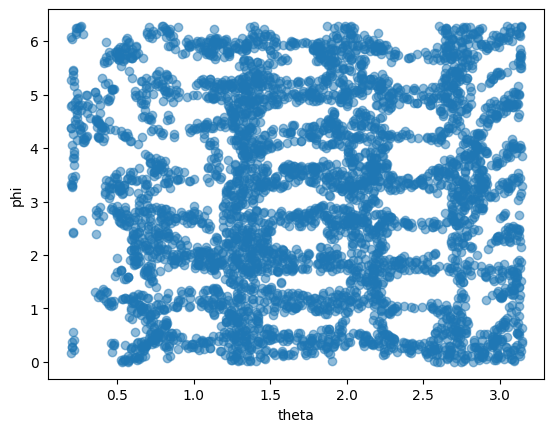

In [6]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

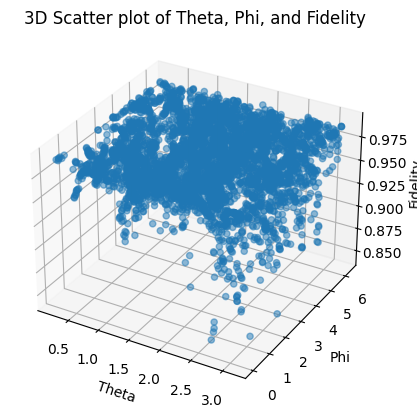

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
